# Advanced Machine Learning

## Classification

The dataset used here is about the Titanic passengers. You can find more information about it on this [website](https://www.kaggle.com/c/titanic/data).

In [1]:
# all the libraries needed for this section of the project
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.metrics import *

### Preparation of the data for the machine learning (ML) models

In [2]:
# reading the train and the test set
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

The train and test datasets have almost the same features, but not the same number of features. Thus the idea is to concatenate them into one dataset and then apply all the modifications about the preprocessing. To do so, we add the feature "Survived" to the test dataset and set it value to "empty". We also add the feature "info" to both of the datasets, just to differiate them later.

In [3]:
train_data['setType'] = "train"
test_data['setType'] = "test"
test_data['Survived'] = "empty"
train_test = pd.concat([train_data,test_data], sort=False)

In [4]:
# checking if there are missing values in the dataset
train_test.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked        True
setType        False
dtype: bool

As we can see there are some features that have missing values such as : Age, Fare, Cabin, Embarked. So first, we'll tackle the issue with these features.

#### Age

Here, we decided to replace the missing values by random values around the mean more or less the standard deviation.

In [5]:
mean = train_test["Age"].mean()
std = train_test["Age"].std()
is_null = train_test["Age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = train_test["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
train_test["Age"] = age_slice
train_test["Age"] = train_test["Age"].astype(int)

In [6]:
train_test["Age"].isnull().sum()

0

#### Fare

As for some passengers, the fare is equal to 0, which means they pay nothing to embark, it sounds reasonable to assume that it's the same for all the others we don't know the fare. So we'll replace by 0 all the missing values for this feature.

In [8]:
train_test['Fare'] = train_test['Fare'].fillna(0)
train_test['Fare'] = train_test['Fare'].astype(int)

In [9]:
train_test["Fare"].isnull().sum()

0

### Cabin

We notice that the cabin numbers is formed of a letter following by one or more digits. In fact, the letter stand for a deck as there were many decks in Titanic. The digits stand for the number of the cabins. The full cabin number is not that meaningfull here. What we can do instead is to create a new feature "Deck".
The deck is initially a letter from A to G and these letters will be assigned numbers from 1 to 7. The missing values we'll be filled in, depending on the value of the feature "pclass". In fact, each deck is associated with a class number. You can find more information about it [here](https://en.wikipedia.org/wiki/RMS_Titanic).

In [10]:
# assign a number to each cabin number
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

train_test['Cabin'] = train_test['Cabin'].fillna("U0")
train_test['Deck'] = train_test['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
train_test['Deck'] = train_test['Deck'].map(deck)
train_test['Deck'] = train_test['Deck'].fillna(0)
train_test['Deck'] = train_test['Deck'].astype(int)

In [11]:
# now fill the missing value depending on the class of the passengers
deck_missing = (train_test['Deck'].isin([0,8]))

mask1 = deck_missing & (train_test['Pclass'] == 1)
mask2 = deck_missing & (train_test['Pclass'] == 2)
mask3 = deck_missing & (train_test['Pclass'] == 3)

# first class passengers are between the decks A and E
train_test['Deck'] = np.where(mask1,np.random.randint(1,5),train_test['Deck'])
# second class passengers between the decks D and G
train_test['Deck'] = np.where(mask2,np.random.randint(4,7),train_test['Deck'])
# third class passengers are mainly on the deck F
train_test['Deck'] = np.where(mask3,6,train_test['Deck'])

# now we can delete the feature 'Cabin'
train_test.drop('Cabin', axis=1, inplace=True)

In [12]:
train_test["Deck"].isna().sum()

0

#### Embarked

Here there are only two values missing. So we can replace them by the most common, which is 'S'. That means the most of the passengers embarked in Southampton.

In [13]:
train_test.Embarked.describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

In [14]:
train_test.Embarked.isna().sum()

2

In [15]:
common_value = 'S'
train_test['Embarked'] = train_test['Embarked'].fillna(common_value)

In [16]:
train_test["Embarked"].isna().sum()

0

Now as we adressed the issues of missing values, let's get the features into the right type.

In [17]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null object
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null int64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null int64
Embarked       1309 non-null object
setType        1309 non-null object
Deck           1309 non-null int64
dtypes: int64(7), object(6)
memory usage: 143.2+ KB


In [18]:
# mapping gender type with number
genders = {"male": 0, "female": 1}
train_test['Sex'] = train_test['Sex'].map(genders)

# mapping ports name with number
ports = {"S": 0, "C": 1, "Q": 2}
train_test['Embarked'] = train_test['Embarked'].map(ports)

#creation of the feature "nb_relatives"
train_test['Nb_Relatives'] = train_test.Parch + train_test.SibSp

The passenger Id and the ticket number are not really meaningfull in this analysis. The fare and the class are correlated so we can choose only one of them (either Fare or Pclass). Also the information about the relatives of the passengers is not necessary here. We can only the number of relatives per for each passenger. So we'll remove all of the features that won't be usefull for our model later on.

In [19]:
columns_out = ['PassengerId','SibSp','Parch','Ticket','Fare','Name']
train_test = train_test.drop(columns_out, axis=1)

In [20]:
# train set
train_df = train_test[train_test['setType'] == "train"]
train_df = train_df.drop('setType',axis=1)
#converting the feature "Survived" from string to int
train_df.loc[:,'Survived'] = pd.to_numeric(train_df['Survived'], errors='coerce').astype(np.int64)

# test set
test_df = train_test[train_test['setType'] == "test"]
test_df = test_df.drop(['setType','Survived'], axis=1)

### Building some ML models

As the test set does not provide labels, we need to use the predictions on the training set to compare the algorithms with each other.

In [21]:
# preparing the X and Y train set
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df.Survived
X_test  = test_df.copy()

In [39]:
type(Y_train)

pandas.core.series.Series

#### Logistic regression

In [22]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, Y_train.values)
Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

#### Support Vector Machine for Classification (SVC)

In [23]:
svc = SVC(gamma='auto')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)

acc_svc = round(svc.score(X_train, Y_train) * 100, 2)

#### Random Forest

In [24]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

#### Gradient Boosting Classifier

In [25]:
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, Y_train)
Y_prediction = gradient_boost.predict(X_test)

acc_gradient_boost = round(gradient_boost.score(X_train, Y_train) * 100, 2)

Now let's see which is the best model.

In [26]:
results = pd.DataFrame({
    'Model': ['SVC', 'Logistic Regression', 'Random Forest', 'Gradient Boosting Classifier'],
    'Score': [acc_svc, acc_log, acc_random_forest, acc_gradient_boost]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
94.50,Random Forest
87.65,Gradient Boosting Classifier
86.76,SVC
80.47,Logistic Regression


As we can see, the Random Forest classifier goes on the first place. However, let's check how it performs when using cross validation.
The cross validation idea is to split our training set into k-folds. Our model would be trained and evaluated k times using different fold for evaluation everytime, while it would be trained on the remaining k-1 folds.
Here we use k = 10 folds.

In [27]:
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.71111111 0.78888889 0.74157303 0.80898876 0.84269663 0.80898876
 0.82022472 0.80898876 0.83146067 0.77272727]
Mean: 0.7935648621041879
Standard Deviation: 0.03902858243409616


This looks much more realistic than before. Our model has an average accuracy of 79% with a standard deviation of 4 %. The standard deviation shows us, how precise the estimates are.

We can also see the importances of the feature. Basically it's how much they contribute to the prediction.

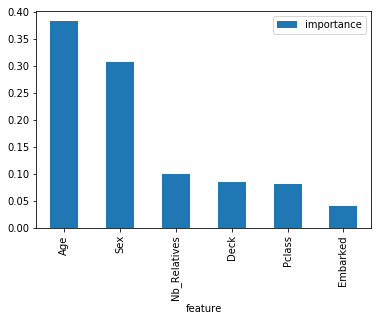

In [28]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

From this figure, we can see that the feature "Embarked", which is the port of embarkation does not play a significant role as the others do. So we can remove it from our dataset.

So the idea is to train the model again without the feature "Embarked" and see what we got. In fact the more feature the more the model overfit. Therefore removing not significant feature can lead to more realistic score.

In [29]:
X_train = X_train.drop("Embarked",axis=1)
X_test = X_test.drop("Embarked",axis=1)

In [30]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

92.59

This score is lower as before what is normal as there are less feature now. Another way to evaluate the random forest classifier is the use of out-of-bag samples to estimate the generalization accuracy.

In [31]:
oob_score = round(random_forest.oob_score_, 4)*100
oob_score

79.12

### Models hyperparameters tuning

There are many hyparameters, so we cannot tune the model using all of them. We select some of them, and each of them has a list of values. In the end, the best combination is shown.
We'll only tune the hyperparameters of the random forest model as it's the best.

In [32]:
param_grid = { "criterion" : ["gini", "entropy"],
                  "min_samples_leaf" : [1, 5, 10],
                  "min_samples_split" : [2, 4, 10, 12],
                  "n_estimators": [100, 400]}

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1,cv=10,iid=False)
clf.fit(X_train, Y_train)
clf.best_params_

{'criterion': 'gini',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

The best parameters could vary, if you rerun the notebook as some variables having missing values were asssigned sometimes random values in the dataset.

So if there is a change, make sure you apply this change in the following cells.

Now we'll test the new parameters.

In [33]:
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 5, 
                                       min_samples_split = 2,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)


round(random_forest.oob_score_, 4)*100

80.92

Now that we have a proper model, we can start evaluating it’s performace in a more accurate way. Before we used, the oob score to do so and now we're going to use other metrics.

#### Confusion matrix, Precision and Recall scores

In [34]:
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=10)

In [35]:
matrix_conf = confusion_matrix(y_true = Y_train, y_pred = predictions)
matrix_conf = matrix_conf * 100 / matrix_conf.sum(axis=1, keepdims=True)
matrix_conf

array([[91.62112933,  8.37887067],
       [31.28654971, 68.71345029]])

The first row of the array is about the non-survived predictions. So we can see 92% were correctly classified as not survived (true negative), while 8% were wrongly classified as not survived (false positive).
The second row of the array is about the survived predictions. So we can see 31% were wrongly classified as survived (false negative), while 69% were correctly classified as survived (true positive).

In [36]:
print("Precision:", precision_score(Y_train, predictions))
print("Recall:", recall_score(Y_train, predictions))

Precision: 0.8362989323843416
Recall: 0.6871345029239766


Our model predicts 84% of the time, a passengers survival correctly.
The recall tells us that it predicted the survival of 69% of the people who actually survived.

#### ROC AUC curve

Another way to evaluate and compare your binary classifier is provided by the ROC AUC Curve. This curve plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances), instead of plotting the precision versus the recall.

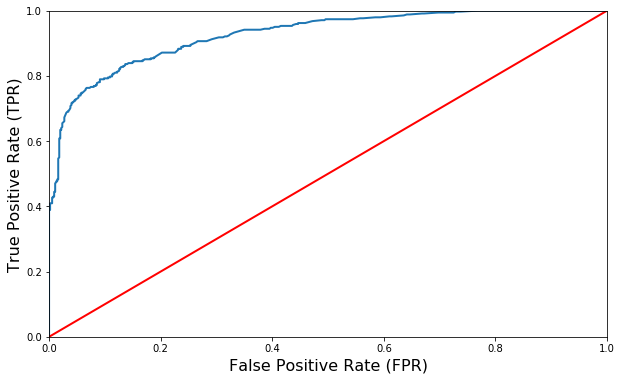

In [37]:
# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)

# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=2)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(10, 6))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

The red line in the middle represents a purely random classifier and therefore the classifier should be as far away from it as possible. The Random Forest model seems to do a good job.

Of course we also have a tradeoff here, because the classifier produces more false positives, the higher the true positive rate is.


#### ROC AUC score

The ROC AUC Score is the corresponding score to the ROC AUC Curve. It is simply computed by measuring the area under the curve, which is called AUC.

A classifier that is 100% correct, would have a ROC AUC Score of 1 and a completely random classiffier would have a score of 0.5.

In [38]:
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9266715665910374


The area under the curve is about 93%, which is not so far from 100%.
So overall, the random forest did a good job.

#### Kaggle submission and score

In [45]:
# predictions to submit to kaggle
sub_data = X_test
sub_data['Survived'] = Y_prediction
sub_data['PassengerId'] = range(892,1310)
sub_data = sub_data.loc[:,['PassengerId','Survived']]
sub_data.to_csv('submission_data.csv', index=False)

After submission, I got **0.74641** as a score.